# Libraries

In [1]:
import numpy as np
from keras.datasets import mnist
from torch.utils.data import Dataset
from typing import Optional
import os
import numpy as np
from PIL import Image
import torch
from torchvision import transforms, utils
from torchvision.utils import make_grid
from torch import nn
import pytorch_lightning as pl
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision
from matplotlib import pyplot as plt
import torchvision.transforms as T

# Data

Загрузим данные и посмотрим на их количество
- В файле **Mnist_X.npy** изображения, в **Mnist_y.npy** - ответы;
- Для тренировки используем первые **60000** экземпляров, для теста -- **10000**.

In [2]:
X = np.load('Mnist_X.npy')
y = np.load('Mnist_y.npy')
print(X.shape)
print(y.shape)

(70000, 28, 28)
(70000,)


In [3]:
train_X, test_X = X[:60000], X[60000:]
train_y, test_y = y[:60000], y[60000:]
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


## Dataset

Создадим класс с данными, который будет реалзовывать все необходимые для обучения сети методы:
- Начальная инициализация:
    - Задаем режим, для которого эти данные выбираются: **тренировка train**, **валидация val**, **тестирование test**;
    - Равномерное деление на валидацию и тестирование: создадим словарь, в котором будем хранить кол-во представителей каждого класса. Когда добавляем элемент, увеличиваем соответствующий счетчик;
    - Задаем параметр деления выборки(в каком соотношении на тренировочную и валидационную). 
- Вернуть длину выборки датасета
- Получить элемент из выбоки:
    - Изображение (28 на 28 пикселей) представить в виде одного вектора длины 784
    - Представить вектор в тип данных для torch и вернуть пару (вектор и метка класса).

In [4]:
# Dataset class
class MyCustomDataset(Dataset):
    def __init__(self, 
                 mode,
                 X,
                 y,
                 fraction: float = 0.8,
                ):
        ## list of tuples: (img, label)
        self._items = []
        train_len = fraction*X.shape[0]
        class_cnt = {i: 0 for i in range(10)}
        class_len = train_len//10
        
        np.random.seed(42)
        if mode == 'train' or mode == 'val':
            for i in range(X.shape[0]):
                if len(self._items) < train_len and class_cnt[y[i]] < class_len:
                    if mode == 'train':
                        self._items.append((X[i], y[i]))
                    class_cnt[y[i]] += 1
                else:
                    if mode == 'val':
                        self._items.append((X[i], y[i]))
                    
        else:
            self._items = list(zip(X, y))
        np.random.shuffle(self._items)

    def __len__(self):
        return len(self._items)

    def __getitem__(self, index):
        img, label = self._items[index]

        img = torch.from_numpy(img.ravel())

        return img, label

In [5]:
ds_train = MyCustomDataset('train', train_X, train_y)

In [6]:
ds_val = MyCustomDataset('val', train_X, train_y)

In [7]:
ds_test = MyCustomDataset('test', test_X, test_y)

In [8]:
len(ds_train), len(ds_val), len(ds_test)

(48000, 12000, 10000)

## Пример

Покажем, как из данных датасета получить изображение и его метку

Цифра 9


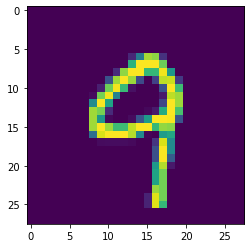

In [9]:
im, label = ds_train[0]
im = im.detach().cpu().numpy().reshape((28, 28))
plt.imshow(im)
print(f'Цифра {label}')

## Упаковываем данные в батчи, которые будут поступать на вход сети

In [10]:
dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, num_workers=0)
dl_val = DataLoader(ds_val, batch_size=32, shuffle=False, num_workers=0)
dl_test = DataLoader(ds_test, batch_size=32, shuffle=False, num_workers=0)

# Model


In [11]:
class MyModel(pl.LightningModule):
    # REQUIRED
    def __init__(self, input_shape=(3, 130, 130), test_data=dl_test, num_classes=10, freeze=True):
        super().__init__()
        """ Define computations here. """
        
        # Описываем модель
        self.fc1 = nn.Linear(784, 100)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)
        
        # Для оценки качества на тестовых данных можем указать 
        # сразу данные, на которых и будет производиться эта оценка
        self.test_data = test_data
        
        # В качестве ошибки выступает кросс-энтропия
        self.loss = F.cross_entropy
        
        # Дополнительно посмотрим на метрику точности, т.к. она более понятна
        self.accuracy = lambda x, y: (x.argmax(-1) == y).float().mean()
    
    # REQUIRED
    def forward(self, x):
        """ Use for inference only (separate from training_step). """
        # Чтобы избежать ошибок, переводим данные в нужный формат
        x = x.type(torch.FloatTensor)
        
        # Описываем поведение сети, т.е. как она проходит 
        # через 1-ый слой, 
        x = self.fc1(x)
        # применяем функцию-срезку
        x = self.act(x)
        # применяем второй слой
        x = self.fc2(x)
    
        return x
    
    # REQUIRED -- в конце каждого этапа обучения будут сохраняться результаты 
    # ошибок и точности на данной эпохе для обуающей выборки
    def training_step(self, batch, batch_idx):
        """the full training loop"""
        x, y = batch
        
        x = x.type(torch.FloatTensor)
        y = y.type(torch.LongTensor)

        y_logit = self(x)
        loss = self.loss(y_logit, y)
        
        acc = self.accuracy(y_logit, y)

        return {'loss': loss, 'acc': acc}

    # REQUIRED -- определяем оптимизатор и задаем learning rate
    # P.s. еще можно указать как менять скорость обучения, 
    #      но тут мало эпох и слишком простая задача для этого
    def configure_optimizers(self):
        """ Define optimizers and LR schedulers. """
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        
        return optimizer
    
    # OPTIONAL -- как и с обучающими, но тут результаты на валидации, чтобы отслеживать переобучение
    def validation_step(self, batch, batch_idx):
        """the full validation loop"""
        x, y = batch

        x = x.type(torch.FloatTensor)
        y = y.type(torch.LongTensor)
            
        y_logit = self(x)
        loss = self.loss(y_logit, y)
        
        acc = self.accuracy(y_logit, y)

        return {'val_loss': loss, 'val_acc': acc}

    # OPTIONAL -- как раз визуализация среднего значения результатов на обучающей выборке
    def training_epoch_end(self, outputs):
        """log and display average train loss and accuracy across epoch"""
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['acc'] for x in outputs]).mean()
        
        print(f"| Train_acc: {avg_acc:.2f}, Train_loss: {avg_loss:.2f}" )
        
        self.log('train_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('train_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)
     
    # OPTIONAL -- то же самое для валидации
    def validation_epoch_end(self, outputs):
        """log and display average val loss and accuracy"""
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        
        print(f"[Epoch {self.trainer.current_epoch:3}] Val_loss: {avg_loss:.5f} Val_accuracy: {avg_acc:.5f}", end= " ")
        
        self.log('val_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('val_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)
    
    # Оценка качества на тестовой выборке
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        acc = self.accuracy(logits, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        
    # Какие данные сеть полагает тестовыми
    def test_dataloader(self):
        return self.test_data

# Обучение

1. Создаем модель
2. Задаем "учителя"
3. Запускаем процесс обучения

In [12]:
m = MyModel()

In [13]:
trainer = pl.Trainer(
    max_epochs=5,
    gpus=0,
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/rw/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1812: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


In [14]:
trainer.fit(m, dl_train, dl_val)

Missing logger folder: /mnt/d/КЗ/Презентации/2nd Task[SOLUTION]/lightning_logs

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 78.5 K
1 | act  | ReLU   | 0     
2 | fc2  | Linear | 1.0 K 
--------------------------------
79.5 K    Trainable params
0         Non-trainable params
79.5 K    Total params
0.318     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

[Epoch   0] Val_loss: 31.37868 Val_accuracy: 0.06250 

/home/rw/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/rw/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[Epoch   0] Val_loss: 0.43922 Val_accuracy: 0.88025 | Train_acc: 0.88, Train_loss: 0.59


Validation: 0it [00:00, ?it/s]

[Epoch   1] Val_loss: 0.21294 Val_accuracy: 0.94225 | Train_acc: 0.93, Train_loss: 0.24


Validation: 0it [00:00, ?it/s]

[Epoch   2] Val_loss: 0.21557 Val_accuracy: 0.94375 | Train_acc: 0.94, Train_loss: 0.21


Validation: 0it [00:00, ?it/s]

[Epoch   3] Val_loss: 0.22048 Val_accuracy: 0.94925 | Train_acc: 0.95, Train_loss: 0.20


Validation: 0it [00:00, ?it/s]

[Epoch   4] Val_loss: 0.22560 Val_accuracy: 0.94942 | Train_acc: 0.95, Train_loss: 0.19


# Результаты на тестовых данных

In [15]:
trainer.test()

/home/rw/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1444: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at /mnt/d/КЗ/Презентации/2nd Task[SOLUTION]/lightning_logs/version_0/checkpoints/epoch=4-step=7500.ckpt
Loaded model weights from checkpoint at /mnt/d/КЗ/Презентации/2nd Task[SOLUTION]/lightning_logs/version_0/checkpoints/epoch=4-step=7500.ckpt
/home/rw/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus o

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9466000199317932
        test_loss           0.23714858293533325
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.23714858293533325, 'test_acc': 0.9466000199317932}]